### Reproduction of Inception Time algo applied to Fofu dataset from paper by Verket

In [1]:
import numpy as np
import torch
from tsai.all import *
from scipy import io

In [2]:
computer_setup()

os             : Linux-4.19.0-18-cloud-amd64-x86_64-with-debian-10.11
python         : 3.7.12
tsai           : 0.2.23
fastai         : 2.5.3
fastcore       : 1.3.27
torch          : 1.9.1+cu102
n_cpus         : 4
device         : cuda (Tesla T4)


In [3]:
default_device()

device(type='cuda', index=0)

In [4]:
TIME_WINDOW = 150 # time steps


In [5]:
data = io.loadmat('expdata.mat', simplify_cells=True)['ed']

Load all conditions and all runs for a single subject

In [6]:
data['CL'].keys()

dict_keys(['t', 'ft', 'fd', 'e', 'u', 'x'])

In [7]:
desired_conds = ['CL', 'CM', 'CH', 'PL', 'PM', 'PH', 'PRL', 'PRM', 'PRH'] # remove non run conditiosn

# as matlab file is loaded as dictionary of conditions with each dictionary having a dictionary
# of variables, with each variable having a dimension 3 array representing time steps per run per subject
# we first iterate over all dictionaries and convert to dimension 5 array for easy slicing :)

# variable indicies on axis=1 are as follow: ['t', 'ft', 'fd', 'e', 'u', 'x']
all_vars_per_cond = []

for cond in desired_conds:
    all_vars_per_cond.append(np.stack(list(data[cond].values())))
    
proc_data = np.stack(all_vars_per_cond)

In [8]:
proc_data.shape # conditions X variables X time step X run_n X subject

(9, 6, 12000, 5, 9)

Now we need to prepare data into 1.5 second segments beginning at each time step in order to prepare the training array

In [9]:
path = Path('./data')
# need to save it to disk as numpy array is too large for ram
x = create_empty_array((4799250, 4, 150), fname='x_disk', path=path, mode='r+')
y = create_empty_array((4799250, ), fname='y_disk', path=path, mode='r+')

var_idx = [1, 3, 4, 5] # select the variables ft, e, u, and x from data
subj_idx = [0, 1, 2, 3, 4, 5, 6, 7, 8] # which subjects to select
run_idx = [0, 1, 2, 3, 4] # which runs to select
cond_idx = [0, 1, 2, 3, 4, 5, 6, 7, 8] # which conditions to select
cond_labels = [0, 0, 0, 1, 1, 1, 2, 2, 2]

i = 0
for cond in cond_idx:
    for subj in subj_idx:
        for run in run_idx:
            for t in range(proc_data.shape[2] - TIME_WINDOW):
                x[i] = proc_data[cond, var_idx, t:t + TIME_WINDOW, run, subj]
                y[i] = cond_labels[cond]

x.shape, y.shape

((4799250, 4, 150), (4799250,))

### Now onto modelling :)

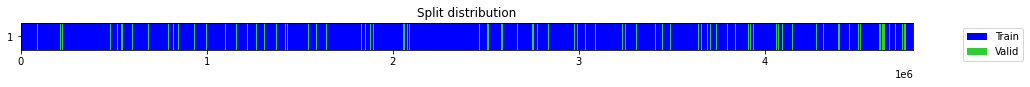

((#4319325) [169511,1284490,2059695,2787891,1006517,4024652,4762515,199146,3603358,683780...],
 (#479925) [4320961,3380026,387415,501018,2259157,2960805,1180237,192677,2496700,2334190...])

In [10]:
# generate the split between train and valid data
splits = get_splits(y, valid_size=0.1, stratify=True, random_state=42, shuffle=True)
splits

In [11]:
tfms = [None, [Categorize()]] # create transforms to change y into categorical variable

In [12]:
# prepare datasets for loading into model
dsets = TSDatasets(x, y, tfms=tfms, splits=splits, inplace=True)

KeyError: "Label '2.0' was not included in the training dataset"

In [ ]:
# now setup dataloaders for loading the data into model on gpu
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=128, batch_tfms=[TSStandardize()], 
                               num_workers=4)

In [ ]:
dls.show_batch(sharey=True)

Beautiful ))

In [ ]:
model = InceptionTime(dls.vars, dls.c)
learner = Learner(dls, model, metrics=accuracy)
#learner.save('stage0')

In [ ]:
#learner = learner.load('stage0')

In [ ]:
learner.lr_find()

In [24]:
learner.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.250643,0.256807,0.897028,01:44
1,0.078891,0.059749,0.979841,01:44
2,0.019828,0.012458,0.996531,01:44
3,0.002386,0.000461,0.999944,01:44
4,0.000189,0.000023,1.000000,01:44
